## Instructions:

(Use the BBC News Category Classification Notebook in the Week 12 folder to import data for this assignment)

Your final report should be written up in a Jupyter notebook.  It should be posted to a public Github repo as an ipynb AND it should be saved as an html file and submitted to this assignment via courseworks.  Please include the link to your Github repo in this html file.

Your report should include the following information:

(Note: Be sure to split your data into training and test sets after importing the csv file with pandas.  You can use sklearn's train_test_split() function to split your data. )

1)  Visualize the categories of your target variable and describe the dataset generally (the data includes news articles from the BBC news.)  A simple description is fine.

2) Preprocess your data such that each document in the data is represented as a sequence of equal length.

3)  Use the data to fit separate models to each of the following architectures:

A. A model with an embedding layer and dense layers (but w/ no layers meant for sequential data)

B. A model using an Embedding layer with Conv1d Layers

C. A model using an Embedding layer with one sequential layer (LSTM or GRU)

D. A model using an Embedding layer with stacked sequential layers (LSTM or GRU)

E. A model using an Embedding layer with bidirectional sequential layers

F. Now retrain your best model from C, D, and E using dropout (you may need to increase epochs!).

4) Discuss 1) which model(s) performed best and speculate about 2) how you might try to further improve the predictive power of your model (e.g. Glove embeddings? More layers? Combining Conv1D with LSTM layers? More LSTM hidden nodes?)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")

df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


## 1)  Visualize the categories of your target variable and describe the dataset generally (the data includes news articles from the BBC news.)  A simple description is fine.

In [32]:
min_length, max_length = 10000, 0

length_total = 0

for i in range(df.shape[0]):

  length = len(df['text'].iloc[i].split())

  length_total += length

  if length < min_length:
    min_length = length
  
  if length > max_length:
    max_length = length

print(f'The shortest text length is {min_length}, and the longest text length is {max_length}. \nThe average text length is {round(length_total/df.shape[0], 1)}')

print(f'The target classes are: {df["category"].unique()}')

The shortest text length is 90, and the longest text length is 4492. 
The average text length is 390.3
The target classes are: ['tech' 'business' 'sport' 'entertainment' 'politics']


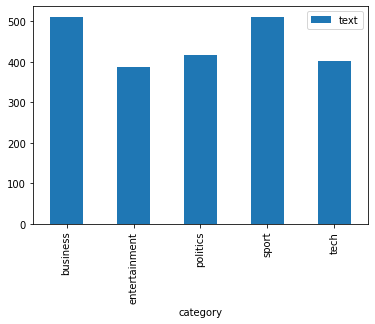

In [43]:
df.groupby('category').count().plot.bar()

plt.show()

There are five target categories: tech, business, sport, entertainment, and politics. The goal is to use the text of each to predict which category is being discussed. The average length in words of the text variable is 390.3; the minimum length is 90 words; the maximum length is 4,492. Each category is pretty evenly represented, with entertainment (the least common) having nearly 400 instances in the dataset while business (the most common) having just over 500 instances.

## 2) Preprocess your data such that each document in the data is represented as a sequence of equal length.

In [0]:
from sklearn.preprocessing import OneHotEncoder

texts = df['text']

categories = df['category']

ohe = OneHotEncoder()

y = ohe.fit_transform(np.asarray(categories).reshape(-1,1))

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 100

max_words = 10000

train_len = 1500

val_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
tok_text = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(tok_text, maxlen=max_len)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = y[indices]

X_train = data[:train_len]
y_train = labels[:train_len]

X_val = data[train_len: train_len + val_len]
y_val = labels[train_len: train_len + val_len]

X_test = data[train_len + val_len:]
y_test = labels[train_len + val_len:]

## 3. Can you build a model... 

### a)... with an embedding layer and dense layers (but w/ no layers meant for sequential data)?

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()

model.add(Embedding(max_words, 256, input_length=max_len))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

batch_size = 256

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 0s 120us/step - loss: 1.6538 - accuracy: 0.2573 - val_loss: 1.5650 - val_accuracy: 0.2320
Epoch 2/20
1500/1500 [==============================] - 0s 42us/step - loss: 1.2758 - accuracy: 0.4400 - val_loss: 1.4306 - val_accuracy: 0.4320
Epoch 3/20
1500/1500 [==============================] - 0s 39us/step - loss: 0.8645 - accuracy: 0.9973 - val_loss: 1.2504 - val_accuracy: 0.6220
Epoch 4/20
1500/1500 [==============================] - 0s 40us/step - loss: 0.4864 - accuracy: 1.0000 - val_loss: 1.0209 - val_accuracy: 0.6960
Epoch 5/20
1500/1500 [==============================] - 0s 45us/step - loss: 0.2157 - accuracy: 1.0000 - val_loss: 0.8458 - val_accuracy: 0.7520
Epoch 6/20
1500/1500 [==============================] - 0s 40us/step - loss: 0.0913 - accuracy: 1.0000 - val_loss: 0.7321 - val_accuracy: 0.7960
Epoch 7/20
1500/1500 [==============================] - 0s 41us/step - loss: 0.043

### b) ... a model using Conv1d Layers?

In [64]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D

model = Sequential()

model.add(Embedding(max_words, 256, input_length=max_len))
model.add(Conv1D(64, kernel_size=2, strides=1))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, kernel_size=4, strides=2))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

batch_size = 256

model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 0s 187us/step - loss: 1.6021 - accuracy: 0.2420 - val_loss: 1.5859 - val_accuracy: 0.3600
Epoch 2/20
1500/1500 [==============================] - 0s 43us/step - loss: 1.4910 - accuracy: 0.4653 - val_loss: 1.4927 - val_accuracy: 0.4200
Epoch 3/20
1500/1500 [==============================] - 0s 43us/step - loss: 1.1475 - accuracy: 0.6367 - val_loss: 1.0656 - val_accuracy: 0.6300
Epoch 4/20
1500/1500 [==============================] - 0s 43us/step - loss: 0.5242 - accuracy: 0.9293 - val_loss: 0.6411 - val_accuracy: 0.7980
Epoch 5/20
1500/1500 [==============================] - 0s 45us/step - loss: 0.1345 - accuracy: 0.9847 - val_loss: 0.4756 - val_accuracy: 0.8380
Epoch 6/20
1500/1500 [==============================] - 0s 46us/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.4336 - val_accuracy: 0.8600
Epoch 7/20
1500/1500 [==============================] - 0s 43us/step - loss: 0.001

### c) ... with one sequential layer (LSTM or GRU)?

In [65]:
from keras.layers import GRU

model = Sequential()

model.add(Embedding(max_words, 256, input_length=max_len))
model.add(GRU(256))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

batch_size = 256

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 2s 2ms/step - loss: 1.8526 - accuracy: 0.1687 - val_loss: 1.6683 - val_accuracy: 0.1780
Epoch 2/20
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6274 - accuracy: 0.2353 - val_loss: 1.6273 - val_accuracy: 0.2160
Epoch 3/20
1500/1500 [==============================] - 2s 1ms/step - loss: 1.5716 - accuracy: 0.2400 - val_loss: 1.5844 - val_accuracy: 0.2240
Epoch 4/20
1500/1500 [==============================] - 2s 1ms/step - loss: 1.5160 - accuracy: 0.2900 - val_loss: 1.5361 - val_accuracy: 0.3480
Epoch 5/20
1500/1500 [==============================] - 2s 1ms/step - loss: 1.3760 - accuracy: 0.5207 - val_loss: 1.3618 - val_accuracy: 0.4560
Epoch 6/20
1500/1500 [==============================] - 2s 1ms/step - loss: 1.0515 - accuracy: 0.5720 - val_loss: 1.1725 - val_accuracy: 0.5860
Epoch 7/20
1500/1500 [==============================] - 2s 1ms/step - loss: 0.7892 - accu

### d) ... with stacked sequential layers (LSTM or GRU)?

In [67]:
model = Sequential()

model.add(Embedding(max_words, 256, input_length=max_len))
model.add(GRU(256, return_sequences=True))
model.add(GRU(256))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

batch_size = 256

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 1.6040 - accuracy: 0.2420 - val_loss: 1.5936 - val_accuracy: 0.3180
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.5442 - accuracy: 0.3800 - val_loss: 1.5095 - val_accuracy: 0.3660
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.2462 - accuracy: 0.5367 - val_loss: 1.2768 - val_accuracy: 0.4400
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9151 - accuracy: 0.6053 - val_loss: 1.1652 - val_accuracy: 0.5220
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6629 - accuracy: 0.7560 - val_loss: 1.0434 - val_accuracy: 0.5960
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3527 - accuracy: 0.9100 - val_loss: 1.0884 - val_accuracy: 0.6580
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1260 - accu

### e) ...with bidirectional sequential layers?

In [70]:
from keras.layers import Bidirectional

model = Sequential()

model.add(Embedding(max_words, 256, input_length=max_len))
model.add(Bidirectional(GRU(256)))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

batch_size = 256

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6029 - accuracy: 0.2607 - val_loss: 1.5948 - val_accuracy: 0.2600
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.5463 - accuracy: 0.3967 - val_loss: 1.5531 - val_accuracy: 0.3440
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 1.3541 - accuracy: 0.4980 - val_loss: 1.2925 - val_accuracy: 0.4840
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0185 - accuracy: 0.6073 - val_loss: 1.0819 - val_accuracy: 0.5720
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6454 - accuracy: 0.8640 - val_loss: 0.9197 - val_accuracy: 0.6620
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2983 - accuracy: 0.9527 - val_loss: 0.8376 - val_accuracy: 0.6660
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1092 - accu

### f) Now retrain your best model from C, D, and E using dropout (you may need to increase epochs!).

In [71]:
model = Sequential()

model.add(Embedding(max_words, 256, input_length=max_len))
model.add(GRU(256, dropout=0.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 30

batch_size = 256

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1500 samples, validate on 500 samples
Epoch 1/30
1500/1500 [==============================] - 3s 2ms/step - loss: 1.8050 - accuracy: 0.2260 - val_loss: 1.6179 - val_accuracy: 0.2340
Epoch 2/30
1500/1500 [==============================] - 2s 1ms/step - loss: 1.6012 - accuracy: 0.2373 - val_loss: 1.6282 - val_accuracy: 0.2160
Epoch 3/30
1500/1500 [==============================] - 2s 2ms/step - loss: 1.5966 - accuracy: 0.2387 - val_loss: 1.6082 - val_accuracy: 0.2160
Epoch 4/30
1500/1500 [==============================] - 2s 2ms/step - loss: 1.5517 - accuracy: 0.2687 - val_loss: 1.5623 - val_accuracy: 0.3100
Epoch 5/30
1500/1500 [==============================] - 3s 2ms/step - loss: 1.4417 - accuracy: 0.4767 - val_loss: 1.4119 - val_accuracy: 0.4380
Epoch 6/30
1500/1500 [==============================] - 3s 2ms/step - loss: 1.1893 - accuracy: 0.5347 - val_loss: 1.3149 - val_accuracy: 0.4840
Epoch 7/30
1500/1500 [==============================] - 2s 2ms/step - loss: 1.0101 - accu

## 4) Discuss 1) which model(s) performed best and speculate about 2) how you might try to further improve the predictive power of your model (e.g. Glove embeddings? More layers? Combining Conv1D with LSTM layers? More LSTM hidden nodes?)

1) Interestingly, the best performing model was a single unidirectional GRU layer of 256 neurons connected to a single dense layer of 256 neurons. One would think that a bidirectional model would be able to perform better since it processes the text in both directions, thus helping it fully understand the semantics of the text better, but nonetheless the simpler model did better. When dropout was added the model performed even better than its original version, albeit after training for 30 epochs instead of 20 (to make up for the fact that dropout increased the time to overfit).

2) The model would certainly have improved with an imported, pre-trained embedding layer such as GloVe or Word2Vec, since these embeddings have already been trained on millions of texts, and so their word embeddings are more representative of the true semantic value of words than the freshly trained embeddings I used for the models in this analysis. I could have also combined 1D convolutional layers with GRU layers, since 1D convolutional layers can be used as both feature extractors and dimensionality reducers (when combined with MaxPooling, usually). Using a convolutional layer (or two) before the GRU layers would allow for a longer sequence of text to be processed, which would probably help the model understand more fully what exactly is being discussed in the text.

I could also have increased the total number of layers of each model and/or increased the number of nodes per layer. However, the risk in those situations is overfitting, since larger models (more trainiable parameters) have a tendency to overfit more than smaller ones. Dropout could be used to mitigate some of this effect, but nonetheless overfitting is still an issue even with dropout. I did try models with larger parameter numbers, but the results were the same as the models above or worse, probably because of an overfitting tendency.